## Scania Truck Failures

### Problem Statement:
The Air Pressure System (APS) is a critical component of a heavy-duty vehicle that
uses compressed air to force a piston to provide pressure to the brake pads, slowing
the vehicle down. The benefits of using an APS instead of a hydraulic system are the
easy availability and long-term sustainability of natural air.
This is a Binary Classification problem, in which the affirmative class indicates that the
failure was caused by a certain component of the APS, while the negative class
indicates that the failure was caused by something else.

### Approach: 
The classical machine learning tasks like Data Exploration, Data Cleaning,
Feature Engineering, Model Building and Model Testing. Try out different machine
learning algorithms that’s best fit for the above case.

### Results: 
You have to build a solution that should able to predict whether a failure of a
Scania Truck component is related to the air pressure system (APS) or not.

### Import required packages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### Reading the data
Training Set

In [2]:
scania_df = pd.read_csv("aps_failure_training_set.csv",skiprows=20,na_values=["na"], nrows=5000)
print(scania_df.shape)
scania_df.head()

(5000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [3]:
print("Total number of Train datapoints: ",scania_df.shape[0])
print("Total number of features: ",scania_df.shape[1])

print("The column/feature names given are:\n ",list(scania_df.columns))

Total number of Train datapoints:  5000
Total number of features:  171
The column/feature names given are:
  ['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc

### Basic Pre-Processing and Analysis¶

Class label Preprocessing

In [4]:
def get_correct_label(y):   
    return y.replace(['neg','pos'],[0,1])

scania_df['class'] = get_correct_label(scania_df['class'])
print(scania_df['class'].unique())

[0 1]


In [5]:
# we need to convert all the data to numeric format
scania_df=scania_df.apply(pd.to_numeric)

### Class Distribution

Here, we will look into the distribution of our dataset. In ideal cases, we prefer a balanced dataset (equal number of positive and negative datapoints)

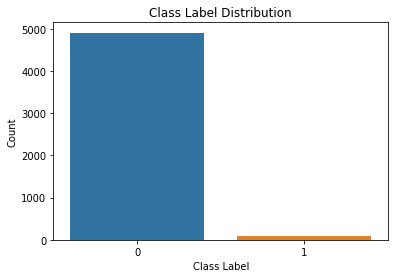

The number of positive class points is:  89
The number of negative class points is:  4911


In [6]:
# Plotting the distribution of class label
sns.countplot(scania_df['class'])
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print('The number of positive class points is: ',scania_df['class'].value_counts()[1])
print('The number of negative class points is: ',scania_df['class'].value_counts()[0])

#### Observation:

This dataset is highly imbalanced as the number of negative class points are much much more than the positive class points. We can choose to upsample the minority class datapoints, or use a modified classifier to tackle this problem.

### Checking for single value features
Out of the available features, the ones that have the same value for all datapoints do not hold much importance in improving performance of our model. Hence, we can discard those features.

We can remove the features that have standard deviation = 0

In [7]:
def constant_value(df):    
    constant_value_feature = []
    info = df.describe()
    for i in df.columns:
        if info[i]['std']==0:
            constant_value_feature.append(i)
    df.drop(constant_value_feature,axis=1,inplace=True)
    return df,constant_value_feature

scania_df , dropped_feature = constant_value(scania_df)
print("The features that are dropped due to having a constant value (0 std. dev.) are: ",dropped_feature)
print("Shape of our feature set: ",scania_df.shape)

The features that are dropped due to having a constant value (0 std. dev.) are:  ['cd_000']
Shape of our feature set:  (5000, 170)


### Missing Values
Our dataset has high number of missing values.

In [8]:
scania_df.isna().sum()

class        0
aa_000       0
ab_000    3884
ac_000     289
ad_000    1214
          ... 
ee_007      65
ee_008      65
ee_009      65
ef_000     228
eg_000     228
Length: 170, dtype: int64

Let's delete the features which has 80% of missing values in it.

In [9]:
scania_df.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=170)

In [10]:
scania_df.columns[scania_df.isnull().mean() < 0.8]

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=168)

In [11]:
df = scania_df[scania_df.columns[scania_df.isnull().mean() < 0.8]]

Features which has 80% missing values are deleted.

Features with missing values less than 5%, we can drop those rows.

In [12]:
nan_5 = df[df.isnull().sum(axis=1)>5]

In [13]:
print(nan_5.shape)
nan_5.head()

(5000, 168)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [14]:
print(nan_5.shape)
nan_5.head()

(4007, 168)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
1,0,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
5,0,38312,NaN,2.130706e+09,218.0,0.0,0.0,0.0,0.0,0.0,...,388574.0,288278.0,900430.0,300412.0,1534.0,338.0,856.0,0.0,0.0,0.0
6,0,14,0.0,6.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,168.0,48.0,60.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df.drop(df[df.isnull().sum(axis=1)>5].index,axis=0,inplace=True)

for col in df.columns:
    df[col] = df[col].replace(np.NaN,df[col].mean())

In [16]:
df.isna().sum()

class       0
aa_000      0
ab_000    766
ac_000      0
ad_000      0
         ... 
ee_007      0
ee_008      0
ee_009      0
ef_000      0
eg_000      0
Length: 168, dtype: int64

In [17]:
df.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,993.000000,9.930000e+02,227.000000,9.930000e+02,993.000000,993.000000,993.000000,9.930000e+02,993.000000,993.000000,...,9.930000e+02,9.930000e+02,9.930000e+02,9.930000e+02,9.930000e+02,9.930000e+02,9.930000e+02,993.000000,993.000000,993.000000
mean,0.019134,9.866559e+04,0.555066,6.136786e+08,1051.820745,27.736153,40.767372,3.715376e+03,896.370594,5931.214502,...,6.746260e+05,3.288527e+05,6.785442e+05,5.981835e+05,5.512016e+05,5.158407e+05,2.183842e+05,13422.392749,0.120846,0.507553
std,0.137065,1.151715e+05,1.831463,9.653519e+08,3217.575757,200.669743,300.506419,1.073735e+05,14866.324818,52294.643793,...,6.806452e+05,3.326185e+05,6.845832e+05,6.635252e+05,8.620964e+05,1.361044e+06,3.229034e+05,37932.465872,2.692863,6.465182
min,0.000000,8.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,4.695800e+04,0.000000,3.220000e+02,188.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,3.872020e+05,1.737140e+05,3.307020e+05,2.726820e+05,1.677700e+05,6.789000e+04,3.014000e+03,0.000000,0.000000,0.000000
50%,0.000000,6.432800e+04,0.000000,1.094000e+03,424.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,5.632100e+05,2.762160e+05,5.639420e+05,4.785480e+05,3.533880e+05,1.923240e+05,7.253400e+04,118.000000,0.000000,0.000000
75%,0.000000,1.001060e+05,0.000000,2.130706e+09,1060.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,8.228960e+05,4.062180e+05,8.428920e+05,7.288620e+05,6.051840e+05,3.812880e+05,3.284820e+05,9050.000000,0.000000,0.000000
max,1.000000,1.047110e+06,18.000000,2.130707e+09,80024.000000,4726.000000,6506.000000,3.376892e+06,402040.000000,967572.000000,...,1.137760e+07,5.432058e+06,1.116599e+07,8.940384e+06,1.409592e+07,1.794006e+07,2.978574e+06,394562.000000,84.000000,144.000000


In [18]:
X = df.drop(['class'],axis=1)

y = df['class']

In [22]:
d = X.isnull().sum()

In [23]:
d.unique()

array([  0, 766,   1,   4,  42,  85, 430, 619, 729,   8], dtype=int64)

### Synthetic Minority Oversampling Technique (SMOTE) for Imbalanced dataset

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
sample = SMOTE()

In [26]:
X_bal,y_bal = sample.fit_resample(X,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
sns.countplot(y_bal)

### Feature Engineering
#### Scaling our Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns,index=X.index)

In [ ]:
X_scaled.head()

from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
principalComponents = pca.fit_transform(X_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

pca = PCA(n_components=100)
new_data = pca.fit_transform(X_scaled)

principal_x = pd.DataFrame(new_data,index=X_scaled.index)
principal_x

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size =0.3)

### Model Building

Try different classification models to predict the best output
here am using 
logistic regression
Support machine vector classifier
K nearest neighbour
Random forest


In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(x_train,y_train)
predictions = logmodel.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, predictions)

In [ ]:
from sklearn.svm import SVC
model = SVC()
model.fit(x_train,y_train)
prediction = model.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,prediction))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, prediction)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
pred = knn.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, pred)


In [ ]:
grid_params ={'n_neighbors': [5,7,9,11,13,15],'weights':['uniform','distance'],'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
# fit the model on our train set
g_res = gs.fit(x_train, y_train)

# find the best score
g_res.best_score_
# get the hyperparameters with the best score
g_res.best_params_

In [ ]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
knn.fit(x_train, y_train)

In [ ]:
# get a prediction
y_hat = knn.predict(x_train)
y_knn = knn.predict(x_test)

In [ ]:
from sklearn import metrics
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_hat))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_knn))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_knn))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_knn))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_knn)

In [ ]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
knn.fit(x_train, y_train)